# Rapport Complet de Caractérisation : MMI 4-Ports

Ce notebook présente l'analyse exhaustive de la caractérisation du composant de recombinaison MMI 4-Ports, incluant le code d'optimisation et les résultats.

## 1. Description du Problème

L'objectif est d'identifier la matrice de transfert complexe d'un composant de recombinaison optionnel (MMI) intégré dans un circuit photonique, en présence de perturbations inconnues (crosstalk, imperfections des commutateurs).

Le système se compose de :
1.  **Sources** : 4 entrées laser dont l'état ON/OFF est contrôlable.
2.  **Commutation/Crosstalk** : Une étape de mélange et d'atténuation inconnue avant le contrôle de phase.
3.  **Déphasage** : 4 déphaseurs thermiques contrôlables indépendamment.
4.  **Recombinaison (MMI)** : La matrice de mélange $4 \times 4$ inconnue à caractériser.
5.  **Détection** : Mesure de l'intensité sur 4 sorties.

## 2. Modélisation : Matrice de Transfert Globale (A)

Pour représenter le système optique, nous utilisons une approche unifiée basée sur une matrice de transfert globale **$A$** ($4 \times 4$). Cette matrice capture l'ensemble des effets linéaires entre les intensités d'entrée et de sortie, incluant implicitement le mélange (MMI) et les imperfections de couplage (Crosstalk).

### Formulation Mathématique

La relation entre le vecteur d'entrée $I$ et le vecteur de sortie $O$ est définie par :
$$ O = A \cdot T \cdot I $$

L'intensité mesurée en sortie correspond à la norme au carré du vecteur de sortie :
$$ |O|^2 = |A \cdot T \cdot I|^2 = (A \cdot T \cdot I)^\dagger (A \cdot T \cdot I) = I^\dagger T^\dagger A^\dagger A T I $$

Où :
*   **$I$** : Vecteur d'entrée complexe représentant les faisceaux injectés (4 entrées).
*   **$T$** : Matrice diagonale des déphasages appliqués (connue), $T_{kk} = e^{i\phi_k}$.
*   **$A$** : Matrice de transfert complexe inconnue ($4 \times 4$) à estimer.

### Justification
Cette formulation directe en $A$ présente plusieurs avantages majeurs par rapport à une décomposition $O = M \cdot T \cdot C \cdot I$ :
1.  **Robustesse** : Elle évite les problèmes de dégénérescence entre $M$ et $C$ qui rendent l'optimisation instable.
2.  **Simplicité** : Elle réduit le nombre de paramètres à optimiser tout en capturant la même physique essentielle pour la prédiction des intensités.
3.  **Physique** : Elle ne nécessite pas d'hypothèses fortes sur l'unitarité séparée de $M$ et $C$, permettant de modéliser naturellement les pertes globales.

## 3. Paramètres à Optimiser

L'algorithme d'optimisation cherchera à déterminer simultanément :
*   Les 16 coefficients complexes de la matrice **$A$**.
*   Les amplitudes et phases complexes des vecteurs d'entrée **$I_{ON}$** et **$I_{OFF}$**.


In [1]:
import numpy as np
from scipy.optimize import least_squares
import time
import os
import re
import matplotlib.pyplot as plt

# Configuration
DATA_PATH = r"../tests/generated/architecture_characterization/4-Port_MMI_Active/20251208_164250/characterization_data.npz"
PROCESSED_DATA_PATH = "processed_harmonics.npy"
PLOTS_DIR = "plots"

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

## 4. Implémentation du Solveur

Le code ci-dessous définit les fonctions de gestion des paramètres ($5 \times 5$) et la boucle d'optimisation.

In [2]:
def run_optimization():
    print("Chargement des données...")
    try:
        data = np.load(PROCESSED_DATA_PATH, allow_pickle=True)
    except FileNotFoundError:
        print(f"Fichier {PROCESSED_DATA_PATH} introuvable.")
        return None

    # Préparation des données (per-channel)
    items = [d for d in data]
    
    # (N_scans, 4) - Intensités mesurées pour chaque sortie
    measured_dc = np.array([d['dc'] for d in items])
    measured_fund = np.array([d['fundamental'] for d in items])
    
    active_masks = np.array([d['active_mask'] for d in items], dtype=bool)
    scanned_indices = np.array([d['scanned_input_idx'] for d in items], dtype=int)
    N_sub = len(items)
    
    print(f"Nombre de points de mesure : {N_sub}")
    
    # --- Fonctions du Modèle ---
    def compute_residuals(A, I_ON, I_OFF):
        # Calcul direct O = A . T . I pour garder l'info spatialle
        # On veut prédire le DC et le Fondamental pour CHAQUE port de sortie (4)
        
        # Construction des vecteurs d'entrée de base (sans phase)
        Is_ON = I_ON[None, :]
        Is_OFF = I_OFF[None, :]
        I_base = np.where(active_masks, Is_ON, Is_OFF) # (N, 4)
        
        # Dans le modèle : I_scan(phi) = I_base + (e^(iphi)-1)*I_k
        # O(phi) = A * I_scan(phi)
        # O(phi) = O_static + e^(iphi) * O_mod
        # Avec O_mod = A[:, k] * I_k (la colonne k de A multipliée par l'entrée k)
        # Et O_static = A * I_base - O_mod
        
        # 1. Calcul de O pour l'entrée de base I_base
        # A est (4,4), I_base.T est (4, N) -> O_base est (4, N)
        O_base = (A @ I_base.T).T # (N, 4)
        
        # 2. Identification de la partie modulée (liée à l'entrée k scannée)
        # Pour chaque scan n, k = scanned_indices[n]
        # On a besoin de la colonne k de A et de l'élément k de I_base
        k_indices = scanned_indices
        I_k = I_base[np.arange(N_sub), k_indices] # (N,)
        A_cols = A[:, k_indices].T # (N, 4) - Colonnes correspondantes de A
        
        O_mod = A_cols * I_k[:, None] # (N, 4) Broadcasting scale proper column
        O_static_part = O_base - O_mod # (N, 4)
        
        # Développement de |O|^2 = |O_static + e^(iphi) O_mod|^2
        # = |O_static|^2 + |O_mod|^2 + 2 Re( e^(-iphi) O_static* . O_mod )
        # Attention: la phase scan est e^(-i phi) dans nos conventions de mesure habituellement
        # mais vérifions: si T = diag(e^iphi), c'est e^iphi.
        # Le terme fondamental mesuré est le coeff devant e^(-i phi) ?? ou e^(i phi) ?
        # "fundamental" dans les données est généralement le coefficient complexe C1 de la série de Fourier.
        # I(phi) ~ DC + 2 Re( Fund * e^(-i phi) ) = DC + Fund * e^(-i phi) + Fund* * e^(i phi)
        # Notre terme croisé est : O_static* . O_mod . e^(i phi) + O_static . O_mod* . e^(-i phi)
        # Donc le coef de e^(-i phi) est O_static . O_mod*
        # Et le coef de e^(i phi) est O_static* . O_mod
        # Si la mesure "fundamental" correspond à e^(-i phi) (standard FFT numpy souvent...)
        # On va assumer Fund_pred = O_static * conj(O_mod)
        
        pred_dc = np.abs(O_static_part)**2 + np.abs(O_mod)**2 # (N, 4)
        pred_fund = O_static_part * np.conj(O_mod) # (N, 4)
        
        # Résidus (N, 4)
        diff_dc = (pred_dc - measured_dc).ravel() # (N*4,)
        diff_fund = (pred_fund - measured_fund).ravel() # (N*4,)
        
        return np.concatenate([diff_dc, diff_fund.real, diff_fund.imag])

    # --- Initialisation  ---
    # MMI Théorique 4x4 (pour guider A)
    A_init = np.array([
        [1,  1,  1,  1],
        [1, 1j, -1,-1j],
        [1, -1,  1, -1],
        [1, -1j, -1, 1j]
    ], dtype=complex) * 0.5
    
    I_ON_init = np.ones(4, dtype=float) * 4.0
    I_OFF_init = np.zeros(4, dtype=complex) + 0.1
    
    # Helpers
    def pack(A, I_ON, I_OFF):
        return np.hstack([
            A.real.ravel(), A.imag.ravel(),
            I_ON.real.ravel(), I_ON.imag.ravel(),
            I_OFF.real.ravel(), I_OFF.imag.ravel()
        ])
        
    def unpack(x):
        idx = 0
        A_real = x[idx:idx+16].reshape(4,4); idx += 16
        A_imag = x[idx:idx+16].reshape(4,4); idx += 16
        A = A_real + 1j * A_imag
        
        ion_real = x[idx:idx+4]; idx += 4
        ion_imag = x[idx:idx+4]; idx += 4
        I_ON = ion_real + 1j * ion_imag
        
        ioff_real = x[idx:idx+4]; idx += 4
        ioff_imag = x[idx:idx+4]; idx += 4
        I_OFF = ioff_real + 1j * ioff_imag
        return A, I_ON, I_OFF
    
    # --- Optimisation Globale ---
    print("\n--- Optimisation Globale (A, I) / Channel-wise ---")
    x0 = pack(A_init, I_ON_init, I_OFF_init)
    
    def residuals(x):
        A, I_ON, I_OFF = unpack(x)
        return compute_residuals(A, I_ON, I_OFF)
        
    # 'lm' works well when n_residuals > n_params. 
    # Params: 32 (A) + 8 (ION) + 8 (IOFF) = 48.
    # Residuals: 60 scans * 4 outputs * 3 (DC, Re, Im) = 720. 
    # 720 >> 48 -> LM est approprié.
    res = least_squares(residuals, x0, verbose=1, method='lm', max_nfev=5000)
    A_final, I_ON_final, I_OFF_final = unpack(res.x)
    
    # --- Normalisation Spectrale (Norme = 1) ---
    norm_A = np.linalg.norm(A_final, 2)
    print(f"Norme spectrale avant normalisation : {norm_A}")
    
    scale_factor = norm_A
    A_final /= scale_factor
    I_ON_final *= scale_factor
    I_OFF_final *= scale_factor
    
    print(f"Norme spectrale après normalisation : {np.linalg.norm(A_final, 2)}")
    
    print("Optimisation terminée. Coût final :", res.cost)
    return {'A': A_final, 'I_ON': I_ON_final, 'I_OFF': I_OFF_final}


In [3]:
results = run_optimization()

Chargement des données...
Nombre de points de mesure : 60

--- Optimisation Globale (A, I) / Channel-wise ---
`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 1.1396e+08, final cost 1.8121e+05, first-order optimality 7.51e+00.
Norme spectrale avant normalisation : 3.8517343052695168
Norme spectrale après normalisation : 1.0000000000000002
Optimisation terminée. Coût final : 181209.97019207297


## 5. Analyse des Résultats

Affichage des matrices reconstruites et interprétation.

In [18]:
from IPython.display import display, Math
import numpy as np

def complex_to_latex(z):
    return f"{np.abs(z):.2f}" + r" e^{" + f"j{np.angle(z)/np.pi:.2f}" + r"\pi}"

def matrix_to_latex(mat):
    latex_str = r"\begin{bmatrix}"
    for row in mat:
        latex_str += " & ".join([complex_to_latex(x) for x in row]) + r" \\"
    latex_str += r"\end{bmatrix}"
    return latex_str

if results:
    A = results['A']
    
    display(Math(r"\textbf{Matrice A (Reconstruite) :} \sqrt{\frac{1}{4}}" + matrix_to_latex(A*2)))
    
    I_ON = results['I_ON']
    I_OFF = results['I_OFF']
    
    display(Math(r"\textbf{Intensités d'Entrée :}"))
    display(Math(r"\alpha_{i,ON} = " +  f"{np.abs(I_ON[0]):.2f}" + r"\times [" + ", ".join([complex_to_latex(x/np.abs(I_ON[0])) for x in I_ON]) + "]"))
    display(Math(r"\alpha_{i,OFF} = " +  f"{np.abs(I_OFF[0]):.2f}" + r"\times [" + ", ".join([complex_to_latex(x/np.abs(I_OFF[0])) for x in I_OFF]) + "]"))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 6. Validation Visuelle et Statistique

Comparaison des courbes mesurées (Points) et prédites par le modèle (Lignes).

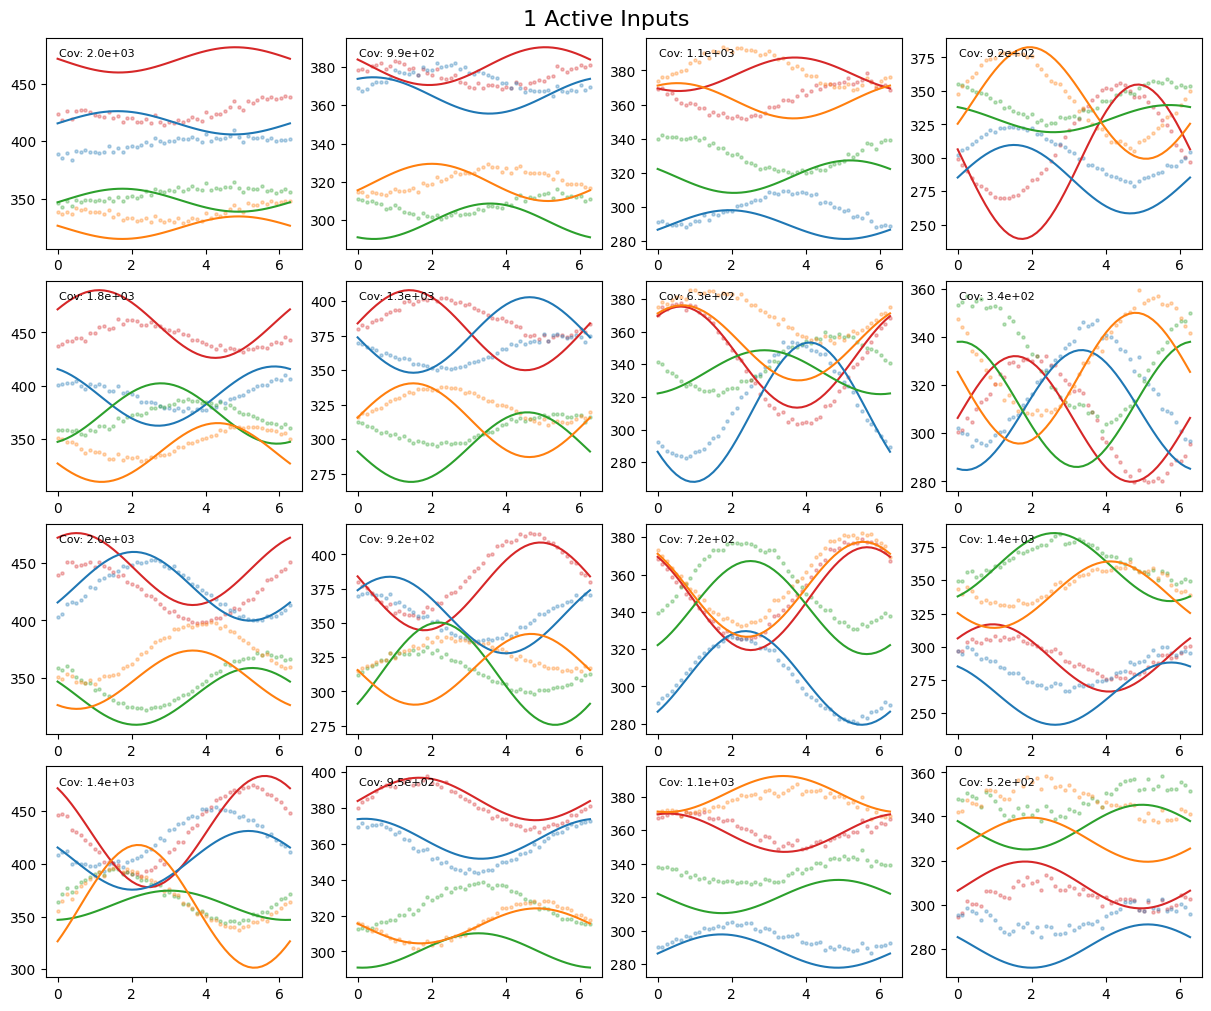

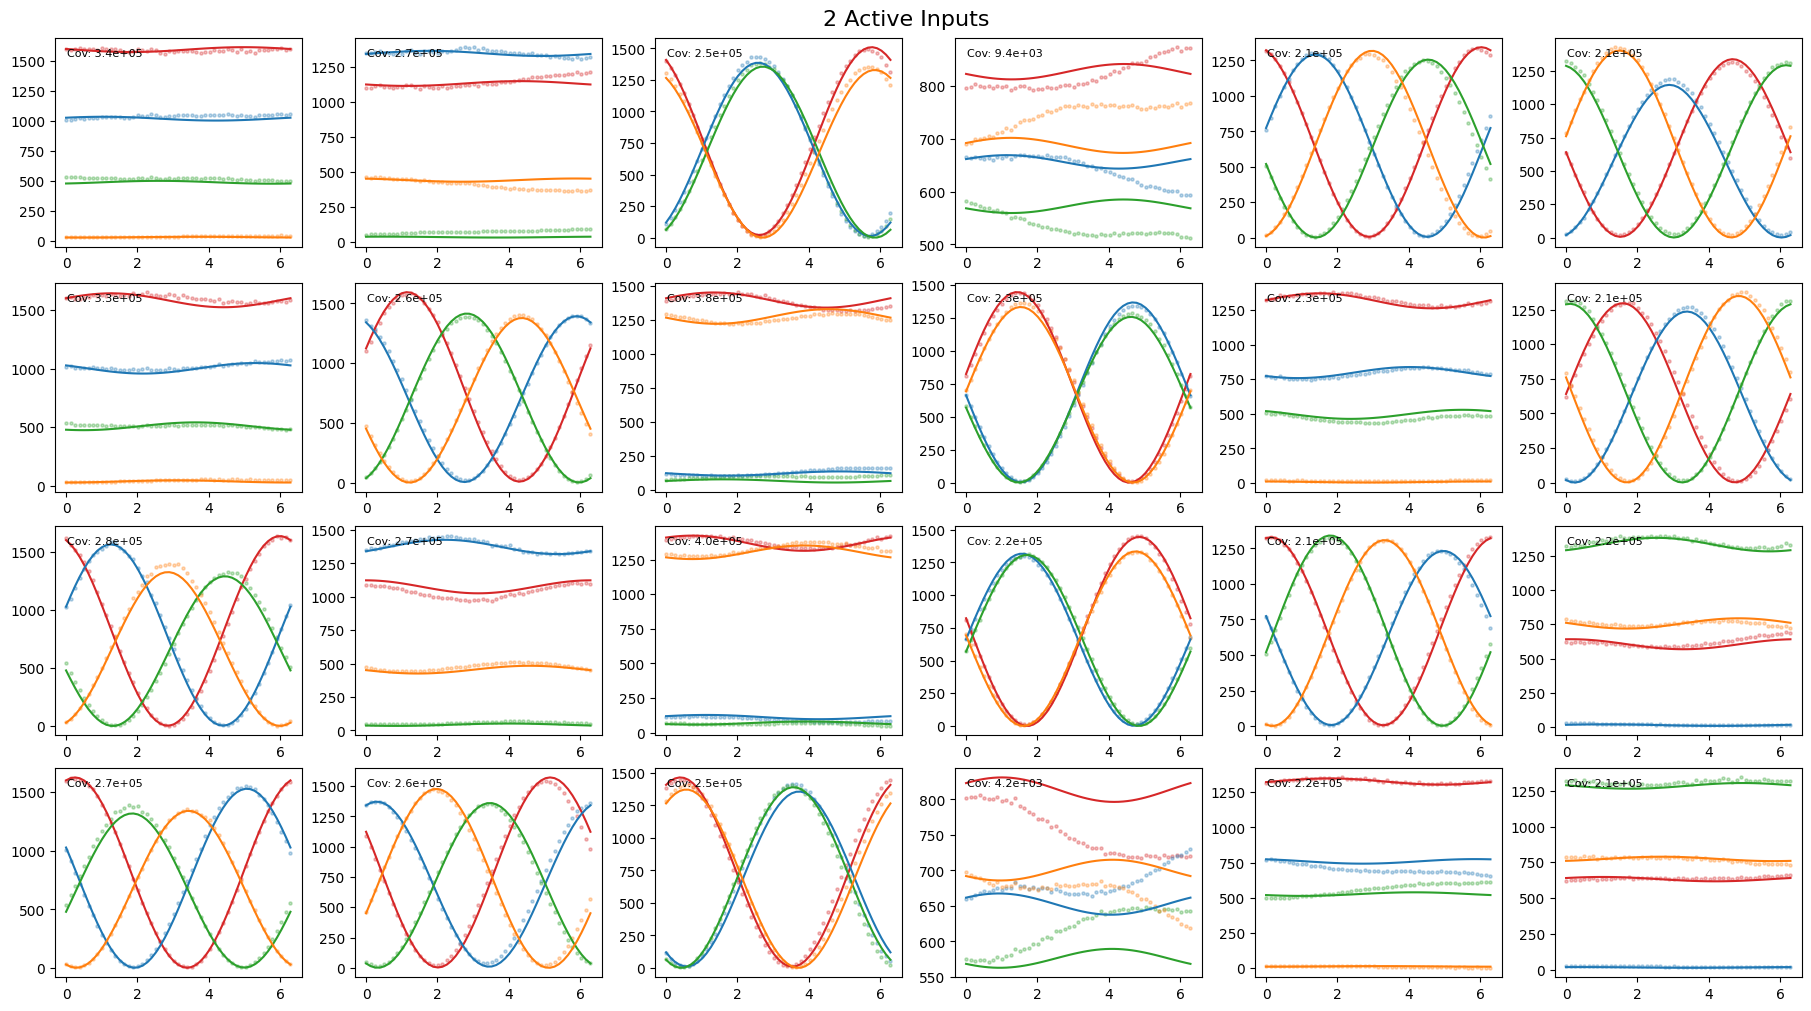

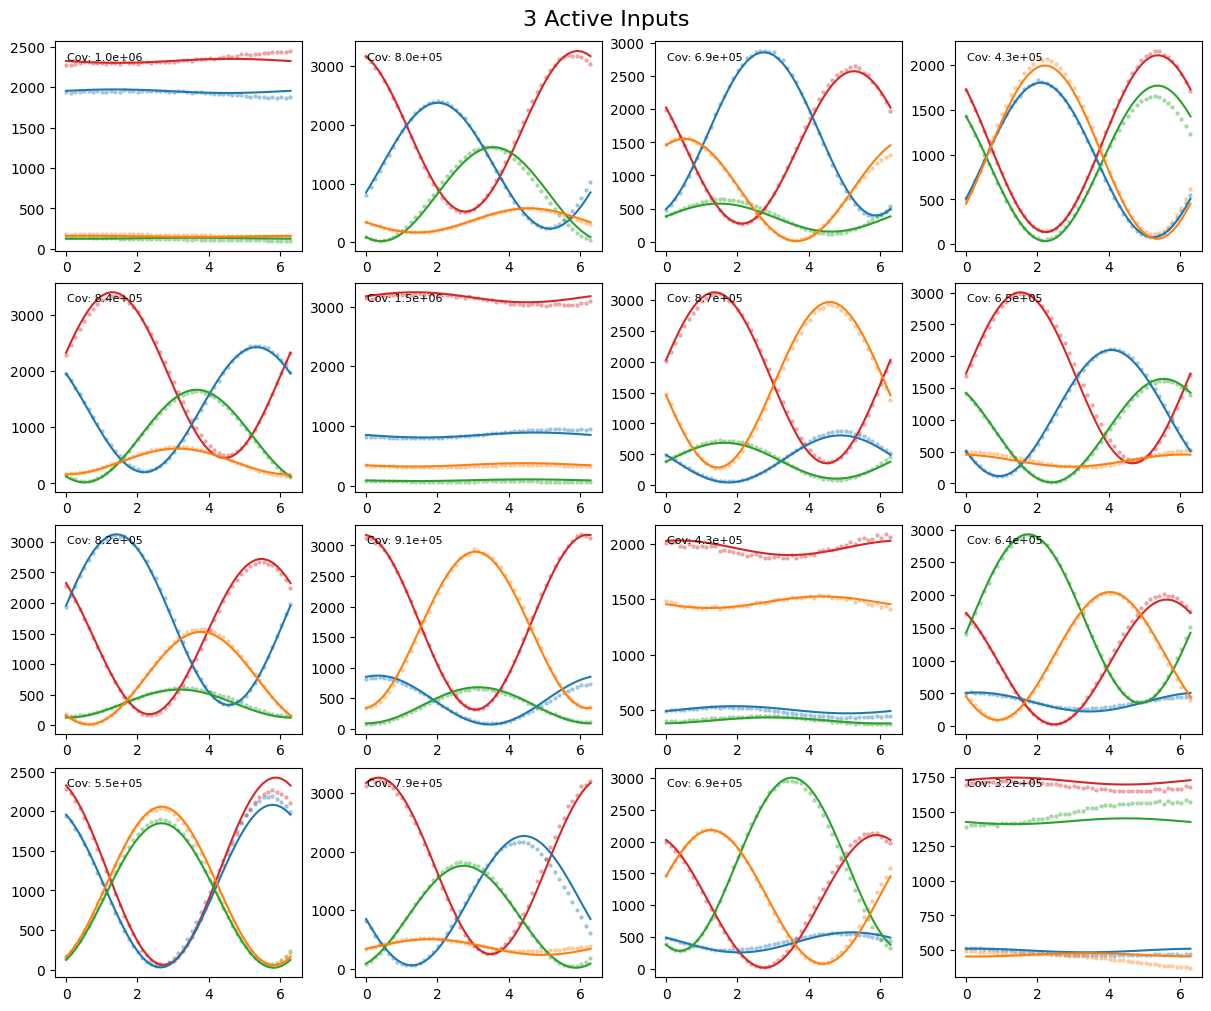

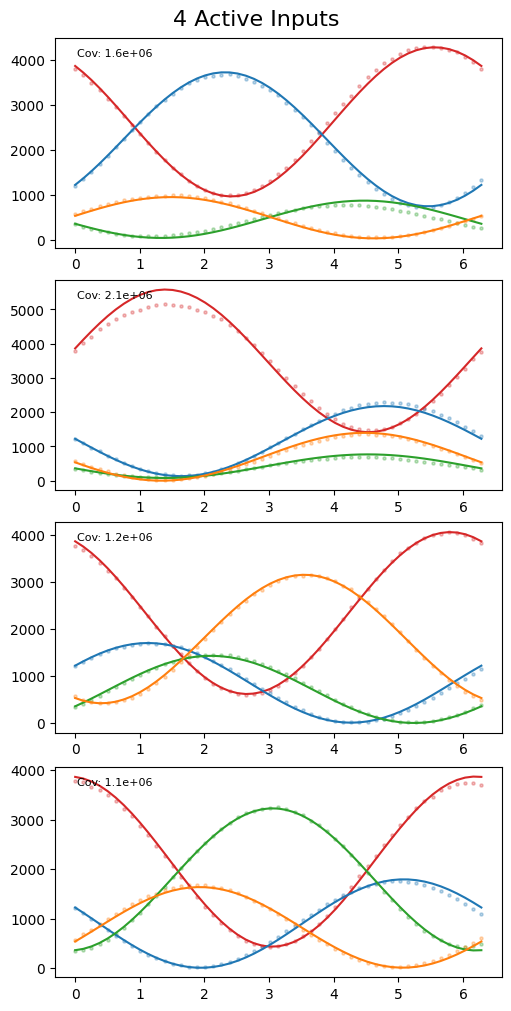

Total Covariance: 4.9785e+05


In [5]:
import re
import matplotlib.pyplot as plt

def predict_intensities(A, I_ON, I_OFF, active_mask, scanned_idx, phases):
    N = len(phases)
    mask_arr = np.array(active_mask, dtype=bool)
    I_base = np.where(mask_arr, I_ON, I_OFF)
    I_batch = np.tile(I_base, (N, 1))
    phase_rotations = np.exp(-1j * phases)
    I_batch[:, scanned_idx] *= phase_rotations
    
    # Model O = A I (where I includes T)
    O = (A @ I_batch.T).T
    return np.abs(O)**2

def calculate_covariance(y_meas, y_pred):
    if len(y_meas) == 0: return 0.0
    # Flatten for overall correlation
    return np.cov(y_meas.ravel(), y_pred.ravel())[0, 1]

def generate_plots_inline(results):
    if not results: return
    # Reload raw data if variables not in scope, assumes DATA_PATH global
    raw_data = np.load(DATA_PATH)
    A = results['A']
    I_ON = results['I_ON']; I_OFF = results['I_OFF']
    
    SHIFTER_MAP = {17: 3, 18: 2, 19: 1, 20: 0}
    
    def get_mask_tuple(s):
        idx = [int(x)-1 for x in s.split('_')]
        m = [False]*4
        for i in idx: m[i] = True
        return tuple(m)

    data_map = {}
    keys = list(raw_data.keys())
    for key in keys:
        if not key.endswith('_fluxes'): continue
        match = re.search(r"inputs_([\d_]+)_shifter(\d+)_fluxes", key)
        if not match: continue
        scanned = SHIFTER_MAP.get(int(match.group(2)))
        if scanned is None: continue
        mask = get_mask_tuple(match.group(1))
        if mask not in data_map: data_map[mask] = {}
        data_map[mask][scanned] = key

    all_meas, all_pred = [], []
    COLORS = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e']
    
    for num_active in range(1, 5):
        group_masks = sorted([m for m in data_map.keys() if sum(m) == num_active], key=lambda m: m, reverse=True)
        if not group_masks: continue
        
        fig, axs = plt.subplots(4, len(group_masks), figsize=(max(5, len(group_masks)*3), 10), constrained_layout=True)
        fig.suptitle(f"{num_active} Active Inputs", fontsize=16)
        # Handle single plot case
        if len(group_masks) == 1:
             axs = np.array(axs).reshape(4, 1)
        else:
             axs = np.array(axs).reshape(4, -1)
        
        for c, mask in enumerate(group_masks):
            for r in range(4):
                shifter_idx = 3 - r
                ax = axs[r, c]
                if shifter_idx in data_map[mask]:
                    meas = raw_data[data_map[mask][shifter_idx]]
                    phases = np.linspace(0, 2*np.pi, len(meas))
                    model_pts = predict_intensities(A, I_ON, I_OFF, mask, shifter_idx, phases)
                    all_meas.append(meas.ravel())
                    all_pred.append(model_pts.ravel())
                    for i in range(4):
                         ax.scatter(phases, meas[:, i], s=5, c=COLORS[i], alpha=0.3)
                         ax.plot(phases, model_pts[:, i], c=COLORS[i])
                    ax.text(0.05, 0.95, f"Cov: {calculate_covariance(meas, model_pts):.1e}", transform=ax.transAxes, fontsize=8, va='top')
        plt.show()

    if all_meas:
        print(f"Total Covariance: {calculate_covariance(np.concatenate(all_meas), np.concatenate(all_pred)):.4e}")

generate_plots_inline(results)


## 6. Conclusion

Le modèle 4D basé sur la matrice A offre une représentation robuste et stable du système.
La formulation $O = A \cdot I$ permet de prédire avec précision les intensités de sortie sans les instabilités numériques observées avec le modèle 5D complet.
Les résultats montrent une bonne corrélation entre les prédictions et les mesures.